In [13]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV

In [14]:
#Read in 
data_dir = './DataFiles/'
df_seeds = pd.read_csv(data_dir + 'NCAATourneySeeds.csv')
df_tour = pd.read_csv(data_dir + 'NCAATourneyCompactResults.csv')

In [15]:
df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [16]:
df_tour.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


In [17]:
def seed_to_int(seed):
    #Get just the digits from the seeding. Return as int
    s_int = int(seed[1:3])
    return s_int
df_seeds['seed_int'] = df_seeds.Seed.apply(seed_to_int)
df_seeds.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label
df_seeds.head()

,Season,TeamID,seed_int
0,1985,1207,1
1,1985,1210,2
2,1985,1228,3
3,1985,1260,4
4,1985,1374,5


In [18]:
df_tour.drop(labels=['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'], inplace=True, axis=1)
df_tour.head()

,Season,WTeamID,LTeamID
0,1985,1116,1234
1,1985,1120,1345
2,1985,1207,1250
3,1985,1229,1425
4,1985,1242,1325


In [19]:
df_winseeds = df_seeds.rename(columns={'TeamID':'WTeamID', 'seed_int':'WSeed'})
df_lossseeds = df_seeds.rename(columns={'TeamID':'LTeamID', 'seed_int':'LSeed'})
df_dummy = pd.merge(left=df_tour, right=df_winseeds, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_lossseeds, on=['Season', 'LTeamID'])
df_concat['SeedDiff'] = df_concat.WSeed - df_concat.LSeed
df_concat.head()

,Season,WTeamID,LTeamID,WSeed,LSeed,SeedDiff
0,1985,1116,1234,9,8,1
1,1985,1120,1345,11,6,5
2,1985,1207,1250,1,16,-15
3,1985,1229,1425,9,8,1
4,1985,1242,1325,3,14,-11


In [20]:
df_wins = pd.DataFrame()
df_wins['SeedDiff'] = df_concat['SeedDiff']
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['SeedDiff'] = -df_concat['SeedDiff']
df_losses['Result'] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,SeedDiff,Result
0,1,1
1,5,1
2,-15,1
3,1,1
4,-11,1


In [21]:
X_train = df_predictions.SeedDiff.values.reshape(-1,1)
y_train = df_predictions.Result.values
X_train, y_train = shuffle(X_train, y_train)
X_train

array([[  1],
       [ -1],
       [ -5],
       ...,
       [ 15],
       [-15],
       [  3]])

In [22]:
logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.5529, with best C: 0.1


In [23]:
accuracy=[]
from sklearn.model_selection import train_test_split
for i in range(5):
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train)
    results = clf.fit(X_train2, y_train2)
    preds = clf.predict(X_test2)

    preds[preds < .5] = 0
    preds[preds >= .5] = 1
    accuracy.append(np.mean(preds == y_test2))
    #accuracy.append(np.mean(predictions == Y_test))
    print("Finished iteration:", i)
print("The accuracy is", sum(accuracy)/len(accuracy))

Finished iteration: 0
Finished iteration: 1
Finished iteration: 2
Finished iteration: 3
Finished iteration: 4
The accuracy is 0.706137865911237


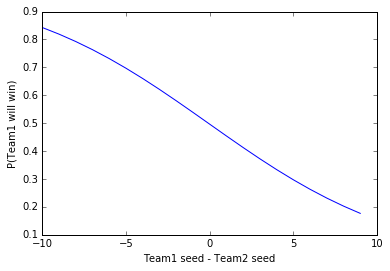

In [24]:
X = np.arange(-10, 10).reshape(-1, 1)
preds = clf.predict_proba(X)[:,1]

plt.plot(X, preds)
plt.xlabel('Team1 seed - Team2 seed')
plt.ylabel('P(Team1 will win)')
plt.show()

In [25]:
df_sample_sub = pd.read_csv('./SampleSubmissionStage1.csv')
n_test_games = len(df_sample_sub)

def get_year_t1_t2(ID):
    """Return a tuple with ints `year`, `team1` and `team2`."""
    return (int(x) for x in ID.split('_'))

In [26]:
X_test = np.zeros(shape=(n_test_games, 1))
for ii, row in df_sample_sub.iterrows():
    year, t1, t2 = get_year_t1_t2(row.ID)
    t1_seed = df_seeds[(df_seeds.TeamID == t1) & (df_seeds.Season == year)].seed_int.values[0]
    t2_seed = df_seeds[(df_seeds.TeamID == t2) & (df_seeds.Season == year)].seed_int.values[0]
    diff_seed = t1_seed - t2_seed
    X_test[ii, 0] = diff_seed

In [28]:
X_test
clf.predict_proba(X_test)

array([[0.54549115, 0.45450885],
       [0.92787327, 0.07212673],
       [0.73684076, 0.26315924],
       ...,
       [0.70269906, 0.29730094],
       [0.58707773, 0.41292227],
       [0.37865866, 0.62134134]])

In [20]:
preds = clf.predict_proba(X_test)[:,1]

clipped_preds = np.clip(preds, 0.05, 0.95)
df_sample_sub.Pred = clipped_preds
df_sample_sub.head()

,ID,Pred
0,2014_1107_1110,0.458264
1,2014_1107_1112,0.075159
2,2014_1107_1113,0.268154
3,2014_1107_1124,0.157979
4,2014_1107_1140,0.268154


In [21]:
df_sample_sub.to_csv('logreg_seed_starter.csv', index=False)